In [ ]:
#!git clone https://github.com/ztutar/HDA_Project.git

In [ ]:
#cd HDA_Project/

In [1]:
!pip -q install e .

In [2]:
# Import necessary libraries
import os
import glob
import json
import time
import keras
import pandas as pd
import tensorflow as tf
from keras import optimizers, losses, callbacks, metrics

from BAP.utils.dataset_loader import get_rsna_dataset, make_dataset, make_roi_dataset, make_fusion_dataset
from BAP.utils.seeds import set_seeds

from BAP.models.Global_CNN import build_GlobalCNN
from BAP.models.ROI_CNN import build_ROI_CNN
from BAP.roi.ROI_extract import extract_rois_from_heatmap
from BAP.models.Fusion_CNN import build_FusionCNN

from BAP.visualization.plots import *
from BAP.visualization.gradcam import compute_GradCAM
from BAP.visualization.overlay import overlay_cam_on_image

2025-11-10 10:26:01.416581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 10:26:01.473590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 10:26:02.755706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Download dataset
paths = get_rsna_dataset(force_download=False)
print("Paths to dataset files:")
for key, value in paths.items():
    print(f"{key}: {value}")

Paths to dataset files:
root: /home/zeynep/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1
train: /home/zeynep/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_train/images
val: /home/zeynep/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_val/images
test: /home/zeynep/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_test/images


In [4]:
# Load metadata
train_metadata = pd.read_csv("data/metadata/train.csv")
val_metadata = pd.read_csv("data/metadata/validation.csv")
test_metadata = pd.read_csv("data/metadata/test.csv")

# Define image directories
train_image_dir = paths["train"]
val_image_dir = paths["val"]
test_image_dir = paths["test"]


print(f"Train records: {len(train_metadata):,}")
print(f"Validation records: {len(val_metadata):,}")
print(f"Test records: {len(test_metadata):,}")

display(train_metadata.head())
display(val_metadata.head())
display(test_metadata.head())

Train records: 12,611
Validation records: 1,425
Test records: 200


,Image ID,male,Bone Age (months)
0,1377,False,180
1,1378,False,12
2,1379,False,94
3,1380,True,120
4,1381,False,82


,Image ID,male,Bone Age (months)
0,1386,False,30
1,1392,True,162
2,1397,False,18
3,1401,False,132
4,1410,True,57


,Image ID,male,Bone Age (months)
0,4360,True,168.93
1,4361,True,169.65
2,4362,True,73.26
3,4363,True,152.86
4,4364,True,135.46


Sample images from training dataset:


I0000 00:00:1762766769.765758  230478 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


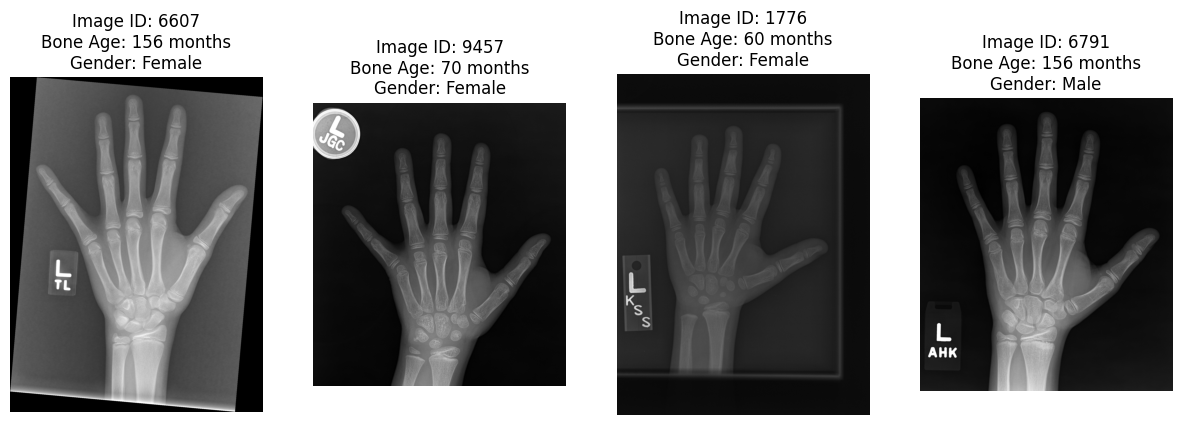

Sample images from validation dataset:


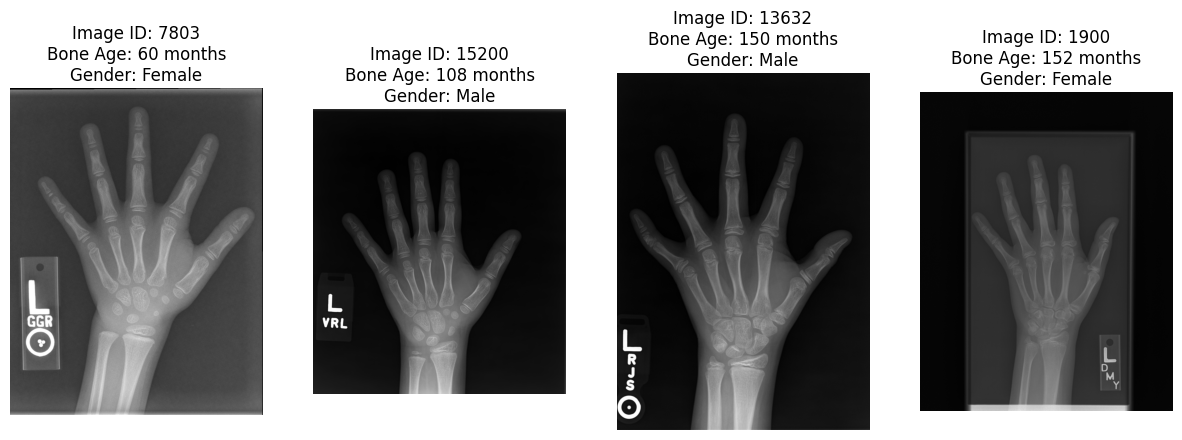

Sample images from test dataset:


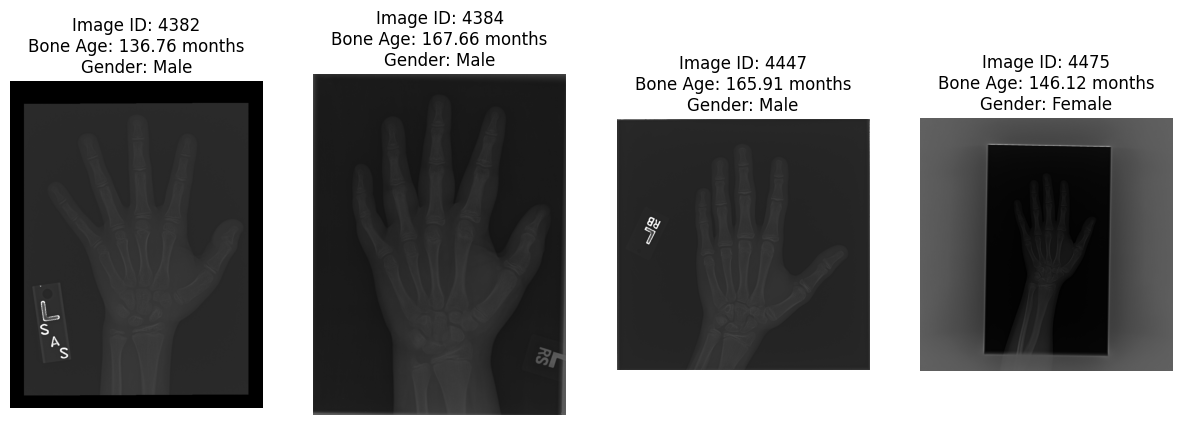

In [5]:
# Display sample images from the train, validation and test datasets
print("Sample images from training dataset:")
display_sample_images(train_metadata, train_image_dir)

print("Sample images from validation dataset:")
display_sample_images(val_metadata, val_image_dir)

print("Sample images from test dataset:")
display_sample_images(test_metadata, test_image_dir)


Distribution plots for training dataset:


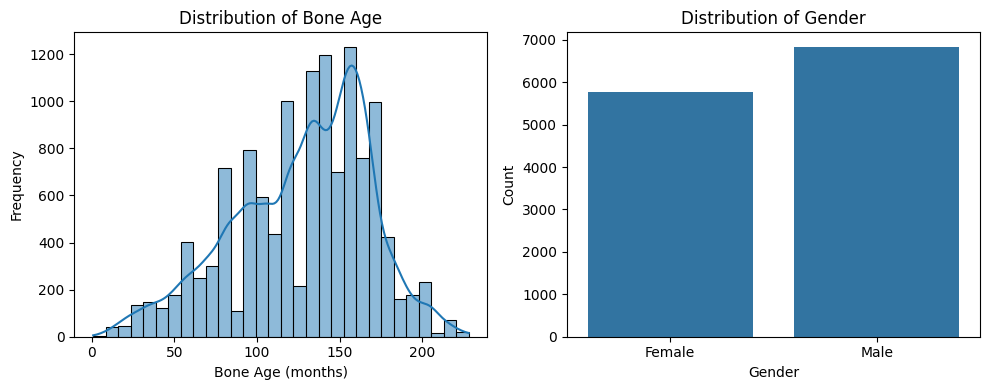

Distribution plots for validation dataset:


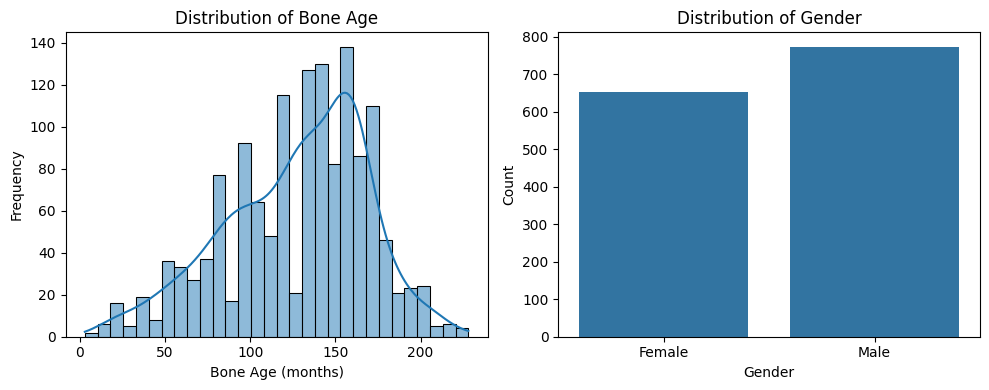

Distribution plots for test dataset:


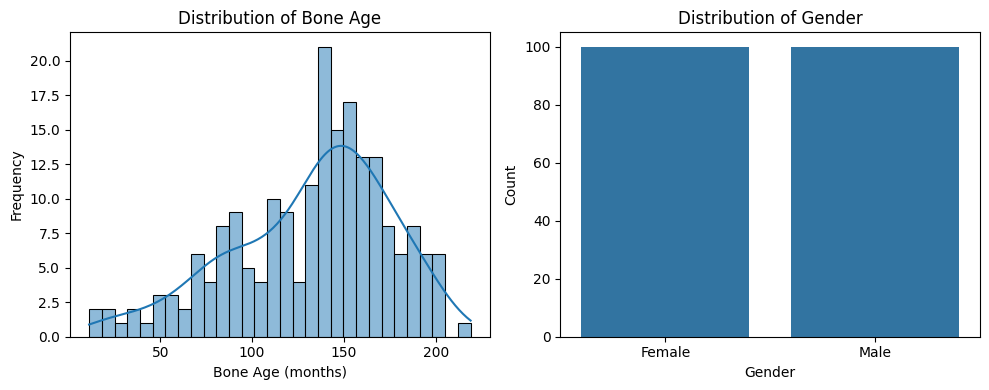

In [6]:
# Plot distributions for train, validation and test datasets
print("Distribution plots for training dataset:")
plot_distributions(train_metadata)

print("Distribution plots for validation dataset:")
plot_distributions(val_metadata)

print("Distribution plots for test dataset:")
plot_distributions(test_metadata)

Sample Raw vs. CLAHE enhanced images from training dataset:


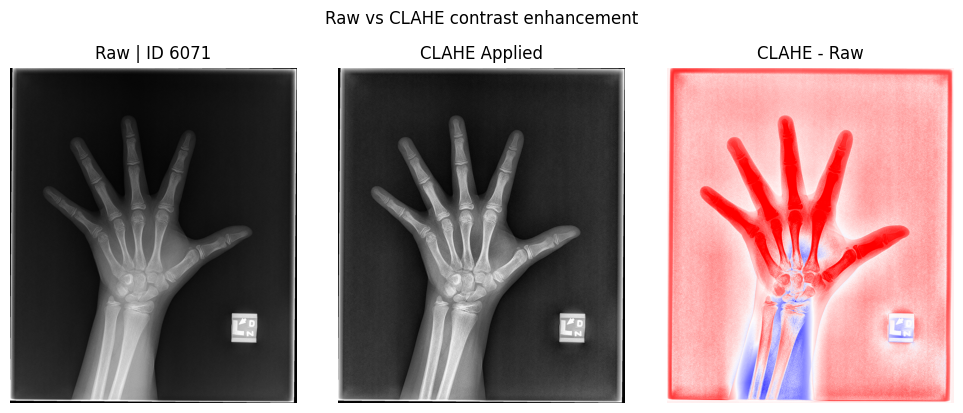

In [7]:
# Display sample Raw vs. CLAHE enhanced images from the train dataset
print("Sample Raw vs. CLAHE enhanced images from training dataset:")
display_raw_vs_clahe_images(train_metadata, train_image_dir)

# Models

In [8]:
# Utility helpers for persisting model metadata between sessions
from typing import Dict, Any


def load_model_dicts(results_path: str) -> Dict[str, Dict[str, Any]]:
    """Load saved model metadata if it exists, otherwise return an empty dict."""
    if not os.path.exists(results_path):
        return {}
    with open(results_path, "r", encoding="utf-8") as fp:
        return json.load(fp)


def save_model_dicts(results: Dict[str, Dict[str, Any]], results_path: str) -> None:
    """Persist the current metadata to disk so it can be reloaded later."""
    tmp_path = f"{results_path}.tmp"
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    with open(tmp_path, "w", encoding="utf-8") as fp:
        json.dump(results, fp, indent=2)
    os.replace(tmp_path, results_path)


In [9]:
# Initialize dicts to store performance metrics and training history for all models
set_seeds()

# Model checkpoints dir
checkpoint_path = "model_checkpoint/"
os.makedirs(checkpoint_path, exist_ok=True)
model_results_path = os.path.join(checkpoint_path, "model_results.json")
model_metrics_path = os.path.join(checkpoint_path, "model_metrics.json")

model_results_dict = load_model_dicts(model_results_path)
model_metrics_dict = load_model_dicts(model_metrics_path)


## 1) Global CNN





### Datasets


In [10]:
# Train dataset
train_ds = make_dataset(train_image_dir, train_metadata, image_size=256, clahe=True)
train_ds = train_ds.map(
    lambda features, age: ({"image": features["image"], "image_viz": features["image_viz"],
                            "image_id": features["image_id"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.batch(16)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_ds = make_dataset(val_image_dir, val_metadata, image_size=256, clahe=True)
val_ds = val_ds.map(
    lambda features, age: ({"image": features["image"], "image_viz": features["image_viz"],
                            "image_id": features["image_id"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds = val_ds.batch(16)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
test_ds = make_dataset(test_image_dir, test_metadata, image_size=256, clahe=True)
test_ds = test_ds.map(
    lambda features, age: ({"image": features["image"], "image_viz": features["image_viz"],
                            "image_id": features["image_id"], 
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_ds = test_ds.batch(16)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


### 1.1) Global CNN Model w/o Gender

In [11]:
# Build Model
model_GlobalCNN = build_GlobalCNN(
    input_shape=(256, 256, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=False,
)

# Compile Model
model_GlobalCNN.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 1.1.1) Model Architecture

In [ ]:
model_GlobalCNN.summary()

In [ ]:
keras.utils.plot_model(model_GlobalCNN, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [12]:
checkpoint_GlobalCNN = os.path.join(checkpoint_path, "GlobalCNN_best.keras")

#### 1.1.2) Train

In [13]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1,
                                        patience=4, min_lr=1e-5, verbose=1)


checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_GlobalCNN, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_GlobalCNN = model_GlobalCNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_GlobalCNN.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_GlobalCNN.history.get("loss", []))
best_epoch_idx = history_GlobalCNN.history["val_mae"].index(min(history_GlobalCNN.history["val_mae"]))

model_results_dict["GlobalCNN"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_dicts(model_results_dict, model_results_path)


Epoch 1/70


2025-11-10 10:26:42.682355: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_6}}
2025-11-10 10:26:45.244413: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 326.7373 - mae: 37.3545 - rmse: 48.1368

2025-11-10 10:34:03.606036: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_6}}



Epoch 1: val_mae improved from None to 97.43401, saving model to model_checkpoint/GlobalCNN_best.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 479s 602ms/step - loss: 246.5188 - mae: 29.2735 - rmse: 38.0074 - val_loss: 924.7227 - val_mae: 97.4340 - val_rmse: 104.2945 - learning_rate: 0.0050
Epoch 2/70
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 190.9529 - mae: 23.6363 - rmse: 30.4745
Epoch 2: val_mae improved from 97.43401 to 29.49398, saving model to model_checkpoint/GlobalCNN_best.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 480s 608ms/step - loss: 162.4278 - mae: 20.7215 - rmse: 26.6619 - val_loss: 248.0377 - val_mae: 29.4940 - val_rmse: 35.7470 - learning_rate: 0.0050
Epoch 3/70
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 166.8885 - mae: 21.1510 - rmse: 27.7297
Epoch 3: val_mae improved from 29.49398 to 20.58418, saving model to model_checkpoint/GlobalCNN_best.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 482s 611ms/step - loss: 143.2322 - mae: 18.7392 - rmse: 24.3196 - val_loss: 160.7081 - val_mae

#### 1.1.3) Test

In [14]:
model_GlobalCNN = keras.models.load_model(checkpoint_GlobalCNN)
predictions_GlobalCNN = model_GlobalCNN.predict(test_ds)

2025-11-10 14:54:31.682520: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_6}}


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step


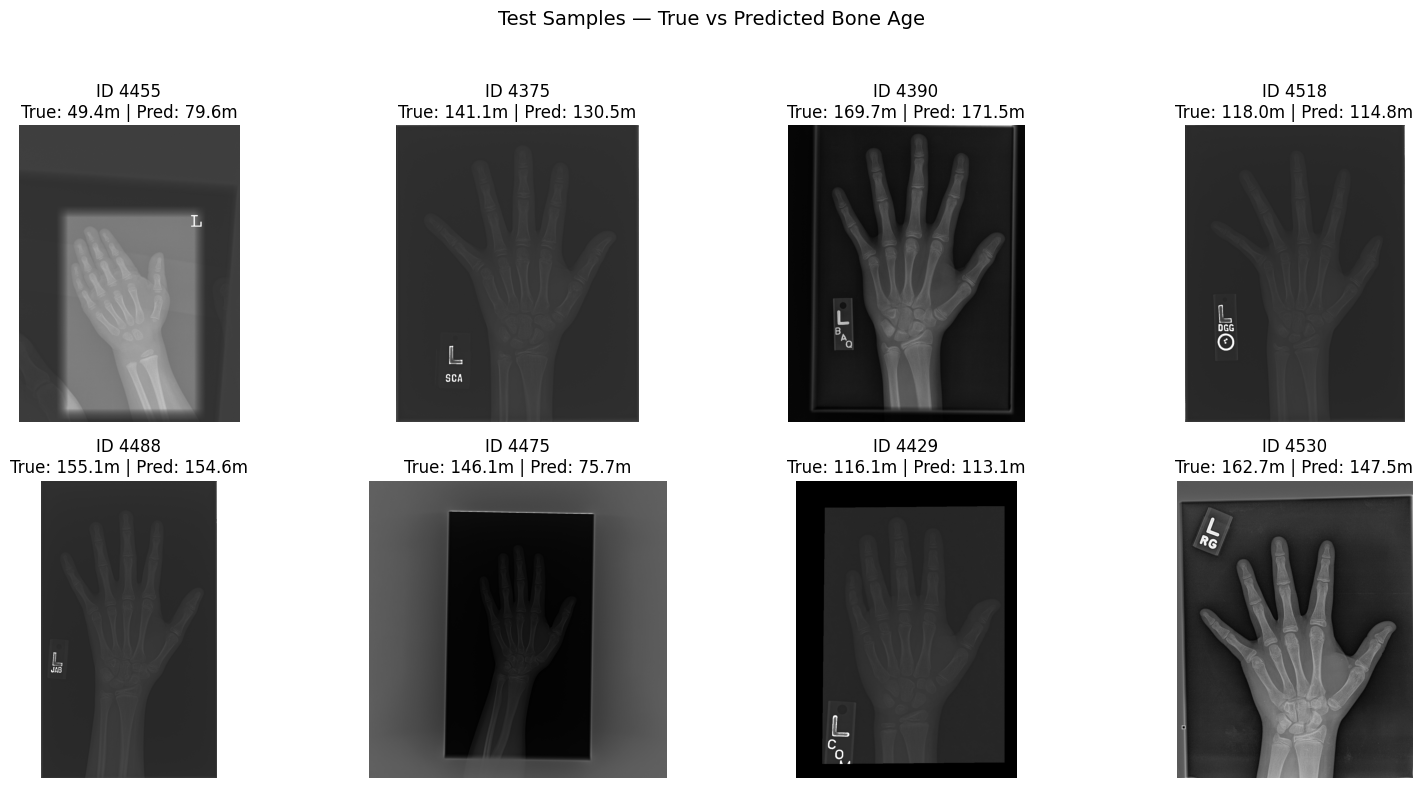

In [15]:
display_test_predictions(test_metadata, predictions_GlobalCNN, test_image_dir, n_samples=8)

#### 1.1.4) Performance Metrics

In [16]:
test_metrics_GlobalCNN = model_GlobalCNN.evaluate(test_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - loss: 12.2761 - mae: 12.7690 - rmse: 16.8429


In [17]:
best_epoch_idx = model_results_dict.get("GlobalCNN", {}).get("best_epoch_idx")
model_metrics_dict["GlobalCNN"] = {
    "history": history_GlobalCNN.history,
    "train_loss": history_GlobalCNN.history["loss"][best_epoch_idx],
    "train_mae": history_GlobalCNN.history["mae"][best_epoch_idx],
    "train_rmse": history_GlobalCNN.history["rmse"][best_epoch_idx],
    "val_loss": history_GlobalCNN.history["val_loss"][best_epoch_idx],
    "val_mae": history_GlobalCNN.history["val_mae"][best_epoch_idx],
    "val_rmse": history_GlobalCNN.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_GlobalCNN["loss"],
    "test_mae": test_metrics_GlobalCNN["mae"],
    "test_rmse": test_metrics_GlobalCNN["rmse"]
}
save_model_dicts(model_metrics_dict, model_metrics_path)

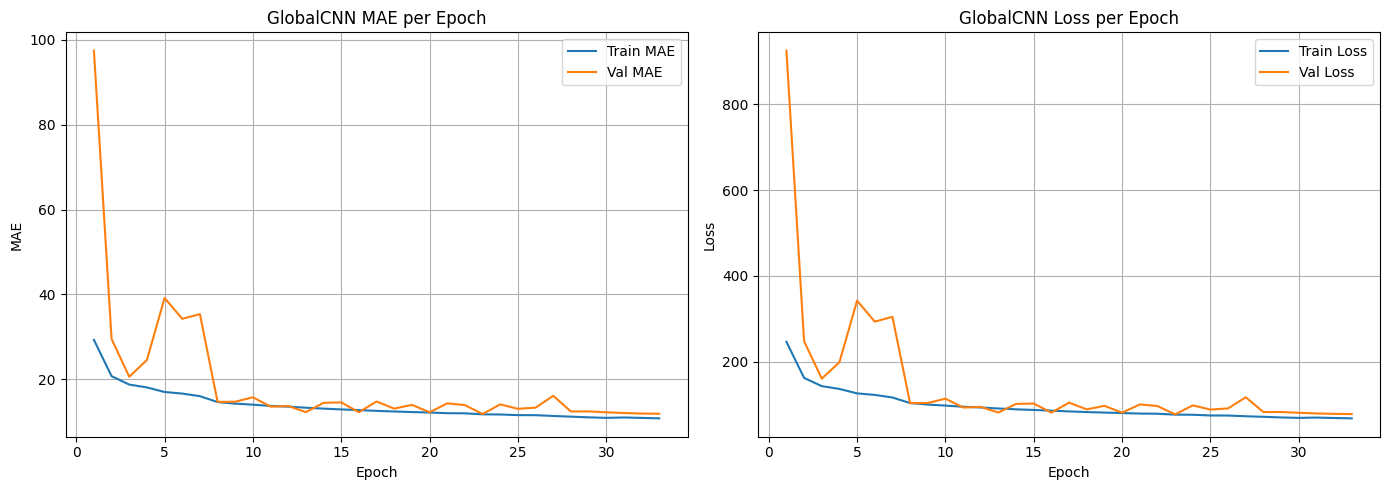

In [18]:
plot_training_metrics(model_metrics_dict["GlobalCNN"], "GlobalCNN")

### 1.2) Global CNN Model with Gender

In [19]:
# Build Model
model_GlobalCNN_Gender = build_GlobalCNN(
    input_shape=(256, 256, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=True,
)

# Compile Model
model_GlobalCNN_Gender.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 1.2.1) Model Architecture

In [ ]:
model_GlobalCNN_Gender.summary()

In [ ]:
keras.utils.plot_model(model_GlobalCNN_Gender, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [20]:
checkpoint_GlobalCNN_Gender = os.path.join(checkpoint_path, "GlobalCNN_Gender_best.keras")

#### 1.2.2) Train

In [21]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1,
                                        patience=4, min_lr=1e-5, verbose=1)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_GlobalCNN_Gender, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_GlobalCNN_Gender = model_GlobalCNN_Gender.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_GlobalCNN_Gender.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_GlobalCNN_Gender.history.get("loss", []))
best_epoch_idx = history_GlobalCNN_Gender.history["val_mae"].index(min(history_GlobalCNN_Gender.history["val_mae"]))

model_results_dict["GlobalCNN_Gender"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_dicts(model_results_dict, model_results_path)


Epoch 1/70
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 309.1711 - mae: 35.5753 - rmse: 46.1636
Epoch 1: val_mae improved from None to 39.61222, saving model to model_checkpoint/GlobalCNN_Gender_best.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 487s 611ms/step - loss: 237.9238 - mae: 28.3932 - rmse: 37.2105 - val_loss: 347.4901 - val_mae: 39.6122 - val_rmse: 45.3164 - learning_rate: 0.0050
Epoch 2/70
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 193.7590 - mae: 23.9051 - rmse: 31.2392
Epoch 2: val_mae did not improve from 39.61222
789/789 ━━━━━━━━━━━━━━━━━━━━ 485s 615ms/step - loss: 156.4735 - mae: 20.0779 - rmse: 26.5226 - val_loss: 528.8112 - val_mae: 57.8140 - val_rmse: 62.8141 - learning_rate: 0.0050
Epoch 3/70
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 155.8994 - mae: 20.0105 - rmse: 26.2692
Epoch 3: val_mae improved from 39.61222 to 39.27205, saving model to model_checkpoint/GlobalCNN_Gender_best.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 485s 615ms/step - loss: 128.0676 - mae: 

#### 1.2.3) Test

In [22]:
model_GlobalCNN_Gender = keras.models.load_model(checkpoint_GlobalCNN_Gender)
predictions_GlobalCNN_Gender = model_GlobalCNN_Gender.predict(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step


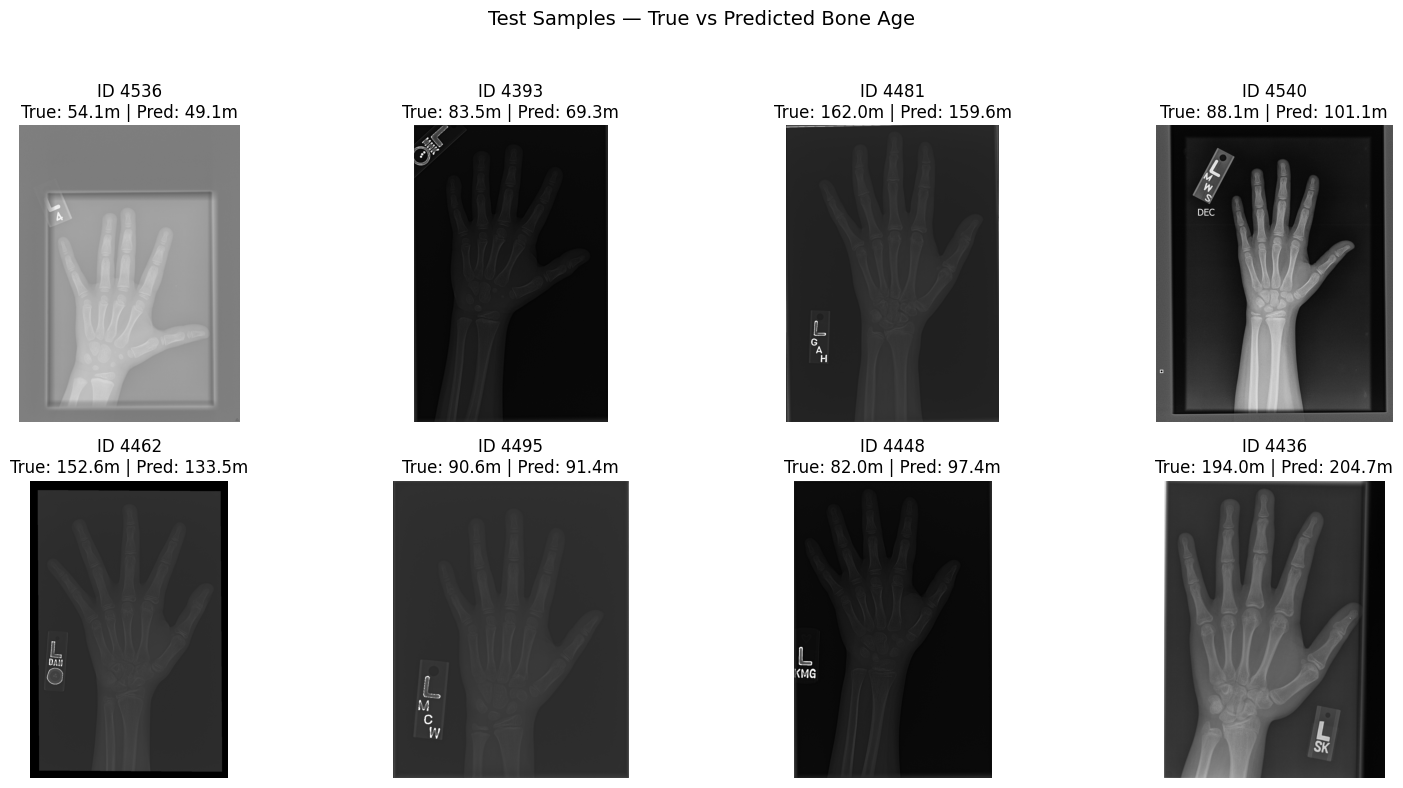

In [23]:
display_test_predictions(test_metadata, predictions_GlobalCNN_Gender, test_image_dir, n_samples=8)

#### 1.2.4) Performance Metrics

In [24]:
test_metrics_GlobalCNN_Gender = model_GlobalCNN_Gender.evaluate(test_ds, return_dict=True, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 9.9759 - mae: 10.4651 - rmse: 15.8450


In [25]:
best_epoch_idx = model_results_dict.get("GlobalCNN_Gender", {}).get("best_epoch_idx")
model_metrics_dict["GlobalCNN_Gender"] = {
    "history": history_GlobalCNN_Gender.history,
    "train_loss": history_GlobalCNN_Gender.history["loss"][best_epoch_idx],
    "train_mae": history_GlobalCNN_Gender.history["mae"][best_epoch_idx],
    "train_rmse": history_GlobalCNN_Gender.history["rmse"][best_epoch_idx],
    "val_loss": history_GlobalCNN_Gender.history["val_loss"][best_epoch_idx],
    "val_mae": history_GlobalCNN_Gender.history["val_mae"][best_epoch_idx],
    "val_rmse": history_GlobalCNN_Gender.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_GlobalCNN_Gender["loss"],
    "test_mae": test_metrics_GlobalCNN_Gender["mae"],
    "test_rmse": test_metrics_GlobalCNN_Gender["rmse"]
}
save_model_dicts(model_metrics_dict, model_metrics_path)

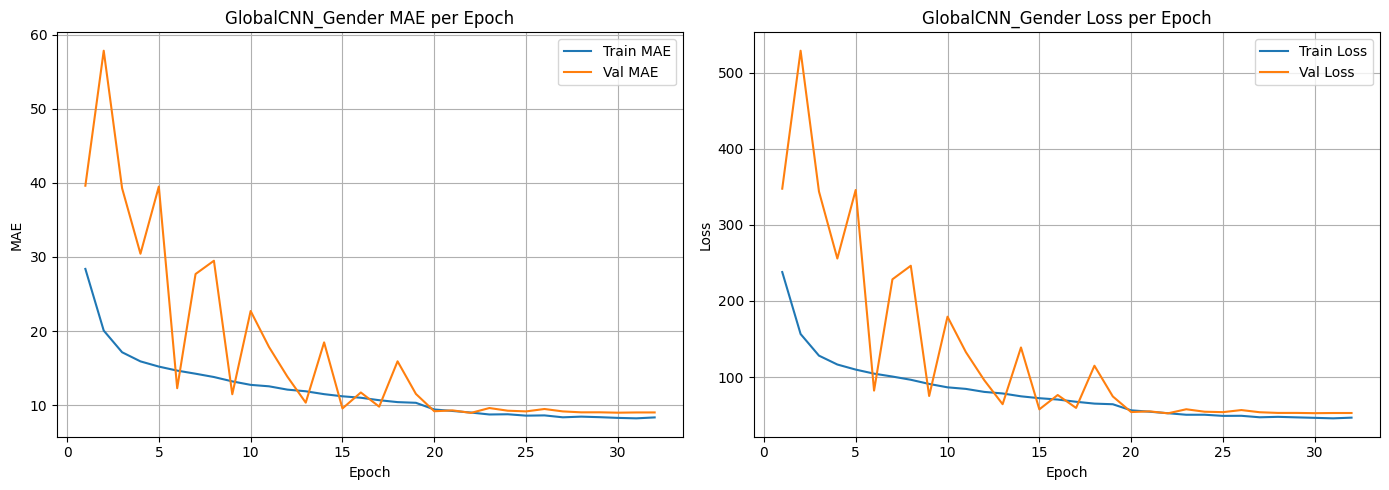

In [26]:
plot_training_metrics(model_metrics_dict["GlobalCNN_Gender"], "GlobalCNN_Gender")

## 2) ROI CNN




### ROI Location & Extraction

In [27]:
def train_locator_and_save_rois(ds:tf.data.Dataset, roi_paths: dict):
  os.makedirs(roi_paths["carpal"], exist_ok=True)
  os.makedirs(roi_paths["metaph"], exist_ok=True)
  os.makedirs(roi_paths["heatmaps"], exist_ok=True)

  # Iterate once over split, save crops
  for features, _ in ds:
    image = features["image"]
    image_viz = features["image_viz"]
    image_id = features["image_id"]

    # Compute Grad-CAM on the locator
    cam = compute_GradCAM(model=model_GlobalCNN, image=image)

    # Extract ROIs from the heatmap
    rois = extract_rois_from_heatmap(
        heatmap=cam,
        image=image_viz,
        roi_size=128,
        carpal_margin=0.48, # extra border around peak box (fraction of shorter side)
        meta_mask_radius=0.35, # mask radius (fraction of shorter side) to hide carpal when finding metacarpal
        heatmap_threshold=0.25,
    )

    img_id = image_id.numpy().decode("utf-8")
    overlay_rgb = overlay_cam_on_image(gray_img=image, cam=cam)

    # Save crops as {image_id}.png
    for key in roi_paths.keys():
      if key == "heatmaps":
        x = tf.convert_to_tensor(overlay_rgb)
      else:
        x = tf.convert_to_tensor(rois[key])
      if x.dtype != tf.uint8:
        if x.dtype.is_floating:
          x = tf.clip_by_value(x, 0.0, 1.0)
          x = tf.image.convert_image_dtype(x, dtype=tf.uint8)
        else:
          x = tf.cast(x, tf.uint8)
      path = os.path.join(roi_paths[key], f"{img_id}.png")
      tf.io.write_file(path, tf.io.encode_png(x))


In [28]:
roi_path = "data/cropped_rois"
if not os.path.exists(roi_path):
  os.makedirs(roi_path)
def has_pngs(path: str) -> bool:
  return os.path.isdir(path) and glob.glob(os.path.join(path, "*.png"))

# Generate crops for each split (train/val/test) if not already present
roi_extraction_time = 0.0
roi_paths = {}
for split in ["train", "validation", "test"]:
  carpal_dir = os.path.join(roi_path, split, "carpal")
  metaph_dir = os.path.join(roi_path, split, "metaph")
  heatmaps_dir = os.path.join(roi_path, split, "heatmaps")
  roi_paths[split] = {
      "carpal": carpal_dir,
      "metaph": metaph_dir,
      "heatmaps": heatmaps_dir
  }
  if not (has_pngs(carpal_dir) and has_pngs(metaph_dir)):
    roi_time_start = time.time()
    if split == "train": ds = train_ds
    elif split == "validation": ds = val_ds
    elif split == "test": ds = test_ds
    train_locator_and_save_rois(ds.unbatch(), roi_paths=roi_paths[split])
    roi_time_end = time.time()
    roi_extraction_time += roi_time_end - roi_time_start

2025-11-10 20:04:48.633062: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_6}}
2025-11-10 20:24:13.901828: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-10 20:24:13.942763: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not

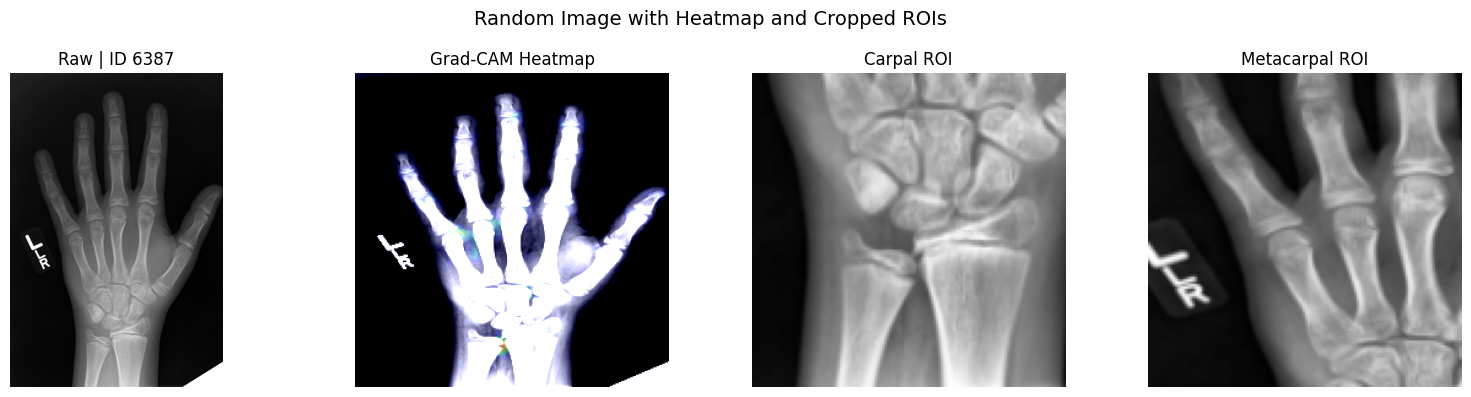

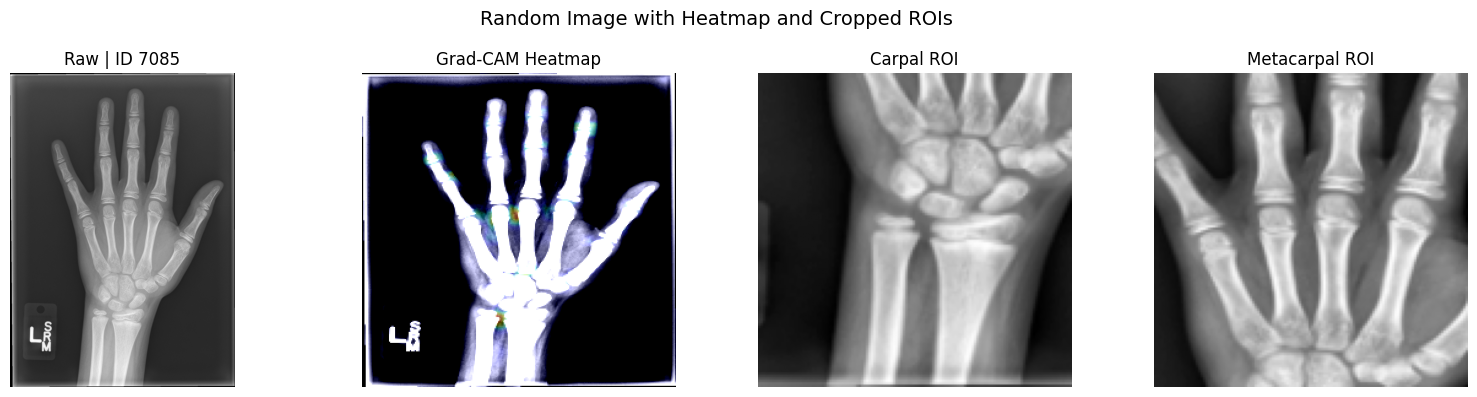

In [29]:
display_image_and_rois(train_metadata, train_image_dir, roi_paths["train"])
display_image_and_rois(val_metadata, val_image_dir, roi_paths["validation"])

### ROI Datasets

In [14]:
# Train dataset
train_ds_roi = make_roi_dataset(roi_paths["train"], train_metadata)
train_ds_roi = train_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds_roi = train_ds_roi.batch(16)
train_ds_roi = train_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_ds_roi = make_roi_dataset(roi_paths["validation"], val_metadata)
val_ds_roi = val_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds_roi = val_ds_roi.batch(16)
val_ds_roi = val_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
test_ds_roi = make_roi_dataset(roi_paths["test"], test_metadata)
test_ds_roi = test_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_ds_roi = test_ds_roi.batch(16)
test_ds_roi = test_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)


### 2.1) ROI CNN Model w/o Gender

In [15]:
# Build Model
model_ROI_CNN = build_ROI_CNN(
    roi_shape=(128, 128, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=False,
)

# Compile Model
model_ROI_CNN.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 2.1.1) Model Architecture

In [ ]:
model_ROI_CNN.summary()

In [ ]:
keras.utils.plot_model(model_ROI_CNN, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [17]:
checkpoint_ROI_CNN = os.path.join(checkpoint_path, "ROI_CNN_best.keras")

#### 2.1.2) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.25,
                                        patience=4, min_lr=1e-6, verbose=1)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_ROI_CNN, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_ROI_CNN = model_ROI_CNN.fit(
    train_ds_roi,
    validation_data=val_ds_roi,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_ROI_CNN.count_params())
training_time = end_train - start_train + roi_extraction_time
num_epochs_ran = len(history_ROI_CNN.history.get("loss", []))
best_epoch_idx = history_ROI_CNN.history["val_mae"].index(min(history_ROI_CNN.history["val_mae"]))

model_results_dict["ROI_CNN"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_dicts(model_results_dict, model_results_path)


#### 2.1.3) Test

In [ ]:
model_ROI_CNN = keras.models.load_model(checkpoint_ROI_CNN)
predictions_ROI_CNN = model_ROI_CNN.predict(test_ds_roi)

In [ ]:
display_test_predictions(test_metadata, predictions_ROI_CNN, test_image_dir, n_samples=8)

#### 2.1.4) Performance Metrics

In [ ]:
test_metrics_ROI_CNN = model_ROI_CNN.evaluate(test_ds_roi, return_dict=True, verbose=1)
best_epoch_idx = model_results_dict.get("ROI_CNN", {}).get("best_epoch_idx")
model_metrics_dict["ROI_CNN"] = {
    "history": history_ROI_CNN.history,
    "train_loss": history_ROI_CNN.history["loss"][best_epoch_idx],
    "train_mae": history_ROI_CNN.history["mae"][best_epoch_idx],
    "train_rmse": history_ROI_CNN.history["rmse"][best_epoch_idx],
    "val_loss": history_ROI_CNN.history["val_loss"][best_epoch_idx],
    "val_mae": history_ROI_CNN.history["val_mae"][best_epoch_idx],
    "val_rmse": history_ROI_CNN.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_ROI_CNN["loss"],
    "test_mae": test_metrics_ROI_CNN["mae"],
    "test_rmse": test_metrics_ROI_CNN["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["ROI_CNN"], "ROI_CNN")

### 2.2) ROI CNN Model with Gender

In [ ]:
# Build Model
model_ROI_CNN_Gender = build_ROI_CNN(
    roi_shape=(128, 128, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=True,
)

# Compile Model
model_ROI_CNN_Gender.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 2.2.1) Model Architecture

In [ ]:
model_ROI_CNN_Gender.summary()

In [ ]:
keras.utils.plot_model(model_ROI_CNN_Gender, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [ ]:
checkpoint_ROI_CNN_Gender = os.path.join(checkpoint_path, "ROI_CNN_Gender_best.keras")

#### 2.2.2) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.25,
                                        patience=4, min_lr=1e-6, verbose=1)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_ROI_CNN_Gender, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_ROI_CNN_Gender = model_ROI_CNN_Gender.fit(
    train_ds_roi,
    validation_data=val_ds_roi,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_ROI_CNN_Gender.count_params())
training_time = end_train - start_train + roi_extraction_time
num_epochs_ran = len(history_ROI_CNN_Gender.history.get("loss", []))
best_epoch_idx = history_ROI_CNN_Gender.history["val_mae"].index(min(history_ROI_CNN_Gender.history["val_mae"]))

model_results_dict["ROI_CNN_Gender"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_results(model_results_dict, model_results_path)


#### 2.2.3) Test

In [ ]:
model_ROI_CNN_Gender = keras.models.load_model(checkpoint_ROI_CNN_Gender)
predictions_ROI_CNN_Gender = model_ROI_CNN.predict(test_ds_roi)

In [ ]:
display_test_predictions(test_metadata, predictions_ROI_CNN_Gender, test_image_dir, n_samples=8)

#### 2.2.4) Performance Metrics

In [ ]:
test_metrics_ROI_CNN_Gender = model_ROI_CNN_Gender.evaluate(test_ds_roi, return_dict=True, verbose=1)
best_epoch_idx = model_results_dict.get("ROI_CNN_Gender", {}).get("best_epoch_idx")
model_metrics_dict["ROI_CNN_Gender"] = {
    "history": history_ROI_CNN_Gender.history,
    "train_loss": history_ROI_CNN_Gender.history["loss"][best_epoch_idx],
    "train_mae": history_ROI_CNN_Gender.history["mae"][best_epoch_idx],
    "train_rmse": history_ROI_CNN_Gender.history["rmse"][best_epoch_idx],
    "val_loss": history_ROI_CNN_Gender.history["val_loss"][best_epoch_idx],
    "val_mae": history_ROI_CNN_Gender.history["val_mae"][best_epoch_idx],
    "val_rmse": history_ROI_CNN_Gender.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_ROI_CNN_Gender["loss"],
    "test_mae": test_metrics_ROI_CNN_Gender["mae"],
    "test_rmse": test_metrics_ROI_CNN_Gender["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["ROI_CNN_Gender"], "ROI_CNN_Gender")

## 3) Fusion CNN

First, run the **ROI Location & Extraction** section.

### Fusion Datasets

In [ ]:
# Train dataset
train_ds_fusion = make_fusion_dataset(train_image_dir, roi_paths["train"], train_metadata,
                                    image_size=256, clahe=True, augment=False)
train_ds_fusion = train_ds_fusion.map(
    lambda features, age: ({"image": features["image"],
                            "carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds_fusion = train_ds_fusion.batch(16)
train_ds_fusion = train_ds_fusion.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_ds_fusion = make_fusion_dataset(val_image_dir, roi_paths["validation"], val_metadata,
                                    image_size=256, clahe=True, augment=False)
val_ds_fusion = val_ds_fusion.map(
    lambda features, age: ({"image": features["image"],
                            "carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds_fusion = val_ds_fusion.batch(16)
val_ds_fusion = val_ds_fusion.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
test_ds_fusion = make_fusion_dataset(test_image_dir, roi_paths["test"], test_metadata,
                                    image_size=256, clahe=True, augment=False)
test_ds_fusion = test_ds_fusion.map(
    lambda features, age: ({"image": features["image"],
                            "carpal": features["carpal"], "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_ds_fusion = test_ds_fusion.batch(16)
test_ds_fusion = test_ds_fusion.prefetch(buffer_size=tf.data.AUTOTUNE)


### 3.1) Fusion CNN Model w/o Gender

In [ ]:
# Build Model
model_FusionCNN = build_FusionCNN(
   global_input_shape=(256, 256, 1),
   roi_shape=(128, 128, 1),
   global_channels=(32, 64, 128),
   roi_channels=(32, 64, 128),
   global_dense_units=64,
   roi_dense_units=64,
   fusion_dense_units=(128, 64),
   dropout_rate=0.2,
   use_gender=False,
)

# Compile Model
model_FusionCNN.compile(
   optimizer=optimizers.Adam(learning_rate=0.0005),
   loss=losses.Huber(delta=10, name="huber"),
   metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 3.1.1) Model Architecture

In [ ]:
model_FusionCNN.summary()

In [ ]:
keras.utils.plot_model(model_FusionCNN, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [ ]:
checkpoint_FusionCNN = os.path.join(checkpoint_path, "FusionCNN_best.keras")

#### 3.1.2) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.25,
                                        patience=4, min_lr=1e-6, verbose=1)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_FusionCNN, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_FusionCNN = model_FusionCNN.fit(
    train_ds_fusion,
    validation_data=val_ds_fusion,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_FusionCNN.count_params())
training_time = end_train - start_train + roi_extraction_time
num_epochs_ran = len(history_FusionCNN.history.get("loss", []))
best_epoch_idx = history_FusionCNN.history["val_mae"].index(min(history_FusionCNN.history["val_mae"]))

model_results_dict["FusionCNN"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_results(model_results_dict, model_results_path)


#### 3.1.3) Test

In [ ]:
model_FusionCNN = keras.models.load_model(checkpoint_FusionCNN)
predictions_FusionCNN = model_FusionCNN.predict(test_ds_fusion)

In [ ]:
display_test_predictions(test_metadata, predictions_FusionCNN, test_image_dir, n_samples=8)

#### 2.1.4) Performance Metrics

In [ ]:
test_metrics_FusionCNN = model_FusionCNN.evaluate(test_ds_fusion, return_dict=True, verbose=1)
best_epoch_idx = model_results_dict.get("FusionCNN", {}).get("best_epoch_idx")
model_metrics_dict["FusionCNN"] = {
    "history": history_FusionCNN.history,
    "train_loss": history_FusionCNN.history["loss"][best_epoch_idx],
    "train_mae": history_FusionCNN.history["mae"][best_epoch_idx],
    "train_rmse": history_FusionCNN.history["rmse"][best_epoch_idx],
    "val_loss": history_FusionCNN.history["val_loss"][best_epoch_idx],
    "val_mae": history_FusionCNN.history["val_mae"][best_epoch_idx],
    "val_rmse": history_FusionCNN.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_FusionCNN["loss"],
    "test_mae": test_metrics_FusionCNN["mae"],
    "test_rmse": test_metrics_FusionCNN["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["FusionCNN"], "FusionCNN")

### 3.2) Fusion CNN Model with Gender

In [ ]:
# Build Model
model_FusionCNN_Gender = build_FusionCNN(
   global_input_shape=(256, 256, 1),
   roi_shape=(128, 128, 1),
   global_channels=(32, 64, 128),
   roi_channels=(32, 64, 128),
   global_dense_units=64,
   roi_dense_units=64,
   fusion_dense_units=(128, 64),
   dropout_rate=0.2,
   use_gender=True,
)

# Compile Model
model_FusionCNN_Gender.compile(
   optimizer=optimizers.Adam(learning_rate=0.0005),
   loss=losses.Huber(delta=10, name="huber"),
   metrics=[metrics.MeanAbsoluteError(name="mae"),
            metrics.RootMeanSquaredError(name="rmse")]
)

#### 3.1.1) Model Architecture

In [ ]:
model_FusionCNN_Gender.summary()

In [ ]:
keras.utils.plot_model(model_FusionCNN_Gender, show_shapes=True, show_layer_names=True)

You can skip the Training part and use the pretrained model from checkpoint for evaluation.

In [ ]:
checkpoint_FusionCNN_Gender = os.path.join(checkpoint_path, "FusionCNN_Gender_best.keras")

#### 3.1.2) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                    verbose=1, mode="min",
                                    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.25,
                                        patience=4, min_lr=1e-6, verbose=1)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_FusionCNN_Gender, monitor='val_mae', mode='min', 
                                        save_best_only=True, save_weights_only=False, verbose=1)

start_train = time.time()
history_FusionCNN_Gender = model_FusionCNN_Gender.fit(
    train_ds_fusion,
    validation_data=val_ds_fusion,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)
end_train = time.time()

num_params = int(model_FusionCNN_Gender.count_params())
training_time = end_train - start_train + roi_extraction_time
num_epochs_ran = len(history_FusionCNN_Gender.history.get("loss", []))
best_epoch_idx = history_FusionCNN_Gender.history["val_mae"].index(min(history_FusionCNN_Gender.history["val_mae"]))

model_results_dict["FusionCNN_Gender"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx
}

save_model_results(model_results_dict, model_results_path)


#### 3.1.3) Test

In [ ]:
model_FusionCNN_Gender = keras.models.load_model(checkpoint_FusionCNN_Gender)
predictions_FusionCNN_Gender = model_FusionCNN_Gender.predict(test_ds_fusion)

In [ ]:
display_test_predictions(test_metadata, predictions_FusionCNN_Gender, test_image_dir, n_samples=8)

#### 2.1.4) Performance Metrics

In [ ]:
test_metrics_FusionCNN_Gender = model_FusionCNN_Gender.evaluate(test_ds_fusion, return_dict=True, verbose=1)
best_epoch_idx = model_results_dict.get("FusionCNN_Gender", {}).get("best_epoch_idx")
model_metrics_dict["FusionCNN_Gender"] = {
    "history": history_FusionCNN_Gender.history,
    "train_loss": history_FusionCNN_Gender.history["loss"][best_epoch_idx],
    "train_mae": history_FusionCNN_Gender.history["mae"][best_epoch_idx],
    "train_rmse": history_FusionCNN_Gender.history["rmse"][best_epoch_idx],
    "val_loss": history_FusionCNN_Gender.history["val_loss"][best_epoch_idx],
    "val_mae": history_FusionCNN_Gender.history["val_mae"][best_epoch_idx],
    "val_rmse": history_FusionCNN_Gender.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_FusionCNN_Gender["loss"],
    "test_mae": test_metrics_FusionCNN_Gender["mae"],
    "test_rmse": test_metrics_FusionCNN_Gender["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["FusionCNN_Gender"], "FusionCNN_Gender")

# Model Comparisons

In [ ]:
compare_training_metrics(model_metrics_dict)

In [ ]:
plot_best_epoch_metrics(model_metrics_dict, model_results_dict)